## Lab 5 Part I: Plotting Contoured Surface Data
<br /><br />

In this week's tutorial, we are going to learn how to grid METAR data so that we can have Python objectively isopleth the observations while also generating surface station plots. 
<br />

### Module Documentation
1. Matplotlib Pyplot: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.html
2. Caropy crs: https://scitools.org.uk/cartopy/docs/latest/reference/crs.html
3. Cartopy Feature: https://scitools.org.uk/cartopy/docs/latest/matplotlib/feature_interface.html
4. Matplotlib Colors: https://matplotlib.org/stable/gallery/color/named_colors.html
5. Matplotlib Contour: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.contour.html
6. Scipy Gaussian Filter: https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.gaussian_filter.html
7. Scipy Griddata function: https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.griddata.html


If you have any questions about the code below, feel free to reach out to me at mpvossen@uwm.edu. I am always willing to further explain the code. <br /> <br />

---

<br />
1. As usual, we start by importing the modules we need for our Python code.

In [1]:
#from the data reading capabilities of metpy (metpy.io) import the METAR reading capability (parse_metar_file)
from metpy.io import parse_metar_file

#from the dates and time code(datetime), import the date and time reading capabilities (datetime)
from datetime import datetime

#import the module to download files from the internet
import requests

#from the interpolate sub module of the scipy module, import the griddata function.  This is what we use to create gridded data.
from scipy.interpolate import griddata

#from metpy's plotting abilities (metpy.plots) import the abilities to create a station plot (StationPlot) and the sky cover symbols (sky_cover)
from metpy.plots import StationPlot, sky_cover

#import the numpy module and save it to the variable np
import numpy as np

#import the cartopy (cartopy) module's coordinate reference system (.crs) and save it to the variable crs
import cartopy.crs as crs

#import the cartopy (cartopy) module's ability to plot geographic data (.feature) and save it to the variable cfeature 
import cartopy.feature as cfeature

#import the pyplot submodule from the matplotlib module and save it to the variable plt
import matplotlib.pyplot as plt

#from the metpy calculations module, import the reduce_point_density function
from metpy.calc import reduce_point_density

#from the ndimage submodule within the scipy module, import the gaussian_filter function
from scipy.ndimage import gaussian_filter

#from metpy's units capabilites, import the units class
from metpy.units import units

#import the module sys
import sys

#this line declares that we would like to look for modules outside the default location.  Here I specify the extra modules directory 
#within the shared_notebook space for synoptic I.
sys.path.insert(0, '/srv/data/shared_notebooks/Synoptic1-AtmSci360/Extra_Modules/')

from min_max import plot_maxmin_points

#from the iowa_metar module (found in the special path above), import the download_alldata function
from iowa_metar import download_alldata

<br /><br />
2. In the cell below define a datetime for August 30, 2021 at 1200 UTC.

In [2]:
file_time = datetime(2021,8,30,12)

<br /><br />
3. In any Python code we create, it is a best practice to avoid repeatedly coding the same thing multiple times.  One way we can avoid making our code repetitive is by putting the code that we will need to call multiple times into a function.  In this lab, we are going to create multiple surface plots for different times, so we should place the data processing and data plotting code in a function.  I've started to create a data processing function for you in the code block below.  Follow the instructions in the code and complete the data processing function.

In [3]:
"""
Below I define a function to process METAR data.  This function downloads, thins, grids, and does a unit conversion on the METAR data.  This function requires the following variables:

INPUT:
    time : DATETIME
        The time for which you would like surface data.
    
OUTPUT:
    metar_data : PANDAS DATAFRAME
        Dataframe containing processed METAR data
    new_pressure : NUMPY ARRAY
        Gridded sea-level pressure data
    new_lat : NUMPY ARRAY
        Latitude values corresponding with the gridded sea-level pressure data
    new_lon : NUMPY ARRAY
        Longitude values corresponding with the gridded sea-level pressure data
    proj : CRS OBJECT
        The projection to use for your map

"""


def process_surface_data(file_time):
    """
    Using the iowa_metar module's download_alldata function, we download the METAR observations for the time we have specified.
    The resulting output will be a StringIO object (like we worked with in Lab 3) that contains the raw METAR data. 
    """
    data_file = download_alldata(file_time)
    
    
    """
    As in Lab 3, setup metpy's METAR parsing function to parse out the data we retrieved from Iowa State (data_file).
    """
    metar_data = parse_metar_file(data_file, month = file_time.month, year=file_time.year)
    
    
    
    """
    Again as in Lab 3, we need to drop any missing values that are in the latitude, longitude, and air_pressure_at_sea_level variables.
    For the gridding process to work these missing values must be removed.
    """
    metar_data = metar_data.dropna(how='any', subset=['latitude', 'longitude', 'air_pressure_at_sea_level'])
    
    """
    Setup a Lambert Conformal Conic Projection centered at 35°N and 95°W.  Have the cone of the Lambert Conformal Conic projection intersect the Earth at 27.5°N and 42.5°N.
    """
    proj = crs.LambertConformal(central_longitude=-95, central_latitude=35, standard_parallels=[27.5,42.5])
    
    """
    Now that we have specified the projection, let's convert the points from the latitude and longitude coordinate system to a coordinate system that works with the projection
    we just specified.  
    """
    point_locs = proj.transform_points(crs.PlateCarree(), metar_data['longitude'].values,metar_data['latitude'].values)
    
    """
    Before we reduce the observation density like we did in Lab 3, we need to grid the data.
    
    The first step to gridding is to define the latitude and longitude grids for each point in our gridded data.
    In the code below, I define our grid to have longitudes ranging from 130°W to 60°W with a resolution of 0.1° (~9 km) and latitudes ranging from
    22°N to 65°N at a resolution of 0.1° (11 km).  Note that the np.arange function includes an extra increment to the end value since
    Python does not include the ending value when creating the list.
    
    np.arange(start, stop, increment)
    
    """
    new_lon = np.arange(-130,-59.9,0.1)
    new_lat = np.arange(22,65.1,0.1)
    
    
    """
    We now need to retrieve the latitude and longitude data from our METAR stations.  
    From the METAR data, retrieve the latitude and longitude values and same them to separate variables.
    """
    metar_latitude =metar_data["latitude"].values
    metar_longitude = metar_data["longitude"].values
    
    
    """
    Since we want to grid the sea-level pressure, we need to pull the sea-level pressure values.
    """
    metar_slp = metar_data['air_pressure_at_sea_level'].values
    
    
    """
    We are now ready to grid our data using scipy's griddata function.  
    In the function below the first argument ((metar_longitude, metar_latitude)) is the METAR station latitude and longitude values.
    The second argument (metar_slp) is the sea-level pressure for each METAR station.  
    The third argument ((new_lon[None,:], new_lat[:,None])) is the grid's latitude and longitude values.  The indexing done to the grid
    latitude and longitude values is to take the new longitude and latitude values and arrange them so they match their dimension.  
    In this sense, new_lat[:,None] arranges the latitude values in a vertical list with the largest values at the top and new_lon[None, :]
    arranges the longitude values in a horizontal list with the largest values on the right side.
    The fourth argument (method='linear') is the method used to grid the data.  Here linear is used as a simple method to interpolate the
    value at each grid.  You can also use the "nearest" option or the "cubic" option.
    """
    new_pressure = griddata((metar_longitude, metar_latitude), metar_slp, (new_lon[None,:], new_lat[:,None]), method='linear')
          
    """
    As in Lab 4's Part I, we can apply a Gaussian filter to smooth the potentially noisy sea-level pressure data.  Sea-level pressure observations
    tend to have a lot of small-scale variability, so that plotting the raw data without smoothing will create a plot with a lot of jagged lines.
    Raw data requires more smoothing than GFS model-derived analysis data, so in this case we set sigma to 8 to apply a longer/larger smoothing scale.
    """
    new_pressure = gaussian_filter(new_pressure, 8)
    
    """
    Now that the data are gridded, we can thin our point observations.  In this case a spacing radius of 
    200 km is needed.
    """
    metar_data = metar_data[reduce_point_density(point_locs, 200000.)]
    
    
    """
    The METAR data are still in the standard METAR units.  Convert the dew point, air temperature, and wind to the appropriate imperial units.
    """
    temps = metar_data["air_temperature"].values * units.degC
    metar_data["air_temperature"] = temps.to(units.degF)
    dews=metar_data["dew_point_temperature"].values * units.degC
    metar_data["dew_point_temperature"] = dews.to(units.degF)

    uwind= metar_data["eastward_wind"].values * units.kt
    vwind= metar_data["northward_wind"].values * units.kt
    
    
    """
    Finally, we return the processed data.
    """
    return metar_data, new_pressure, new_lat, new_lon, proj
    


<br /><br />
4. Call the function we just created, using the datetime object you created in step 2.

In [4]:
metar_data, new_pressure, new_lat, new_lon, proj=process_surface_data(file_time)
metar_data

Downloading: 2021-08-30 12:00:00


,station_id,latitude,longitude,elevation,date_time,wind_direction,wind_speed,wind_gust,visibility,current_wx1,...,air_temperature,dew_point_temperature,altimeter,current_wx1_symbol,current_wx2_symbol,current_wx3_symbol,remarks,air_pressure_at_sea_level,eastward_wind,northward_wind
station_id,,,,,,,,,,,,,,,,,,,,,
TLPC,TLPC,14.02,-61.00,2.0,2021-08-30 12:00:00,80.0,5.0,NaN,9999.00,NaN,...,86.0,75.2,29.94,0,0,0,NOSIG,1014.29,-4.924039e+00,-0.868241
OIZI,OIZI,27.23,60.72,591.0,2021-08-30 12:00:00,210.0,6.0,NaN,10000.00,NaN,...,105.8,33.8,29.65,0,0,0,,997.88,3.000000e+00,5.196152
MZBZ,MZBZ,17.52,-88.30,5.0,2021-08-30 12:00:00,110.0,4.0,NaN,9999.00,NaN,...,82.4,77.0,29.88,0,0,0,Q1012 NOSIG,1012.13,-3.758770e+00,1.368081
CYDL,CYDL,58.42,-130.02,816.0,2021-08-30 12:00:00,200.0,3.0,NaN,NaN,NaN,...,42.8,41.0,29.92,0,0,0,PCPN 0.8MM PAST HR WX MISG VIS MISG PCPN MISG ...,1015.74,1.026060e+00,2.819078
GOGS,GOGS,12.40,-16.75,13.0,2021-08-30 12:00:00,360.0,10.0,NaN,10000.00,NaN,...,86.0,75.2,29.77,0,0,0,,1008.22,2.449294e-15,-10.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PARC,PARC,68.12,-145.58,636.0,2021-08-30 12:56:00,170.0,7.0,NaN,16093.44,NaN,...,44.6,42.8,29.86,0,0,0,AO2 SLP141 T00670056,1013.06,-1.215537e+00,6.893654
PFYU,PFYU,66.56,-145.27,131.0,2021-08-30 12:56:00,0.0,0.0,NaN,16093.44,-RA,...,46.4,44.6,29.99,61,0,0,AO2 SLP166 P0001 T00780072,1016.25,-0.000000e+00,-0.000000
KFLG,KFLG,35.13,-111.67,2134.0,2021-08-30 12:57:00,0.0,0.0,NaN,16093.44,NaN,...,60.8,48.2,30.22,0,0,0,AO2 SLP127 T01560089,1016.81,-0.000000e+00,-0.000000


<br /><br />
5.  Since we are making multiple plots of the same map, lets also put our map code into a function.  Fill out the function where you are asked to do so in the comments below.

In [5]:
"""
Below I define a function to plot surface data in station-model format and sea-level pressure contours
from the gridded data obtained above.

INPUT:

    raw_data : PANDAS DATAFRAME
        The dataframe containing the METAR data
    date : DATETIME
        The time for which the plot is valid
    pressure_grid : NUMPY ARRAY
        The gridded pressure data
    lat_grid : NUMPY ARRAY
        Latitude values corresponding with the gridded sea-level pressure data
    lon_grid : NUMPY ARRAY
        Longitude values corresponding with the gridded sea-level pressure data
    proj : CRS OBJECT
        The projection you are going to use for your map

"""

def plot_surface(raw_data, date, pressure_grid, lat_grid, lon_grid, proj):

    
    """
    Create a figure with a size of 1000px x 1500px and a resolution of 300 dots per inch,
    then set up an axes object (named ax) using the projection we previously defined for our map.
    """
    fig = plt.figure(figsize=(10,15),dpi=300)
    
    ax = plt.subplot(projection = proj)
    
    
    """
    Add the appropriate amount of geographic data.  Be sure you follow "good map" suggestions with the geographic data styling.
    """

    ax.add_feature(cfeature.LAND.with_scale('50m'), edgecolor = "black", facecolor='none',  linewidth=0.75, zorder=2)
    ax.add_feature(cfeature.BORDERS.with_scale('50m'), edgecolor = "black",  facecolor='none', linewidth=0.75, zorder=2)
    ax.add_feature(cfeature.STATES.with_scale('50m'), edgecolor = "grey", linestyle=":", facecolor='none', linewidth=0.5, zorder=1)

    
    
    """
    Limit the map to areas between 125°-65°W longitude and 23°-60°N latitude.
    """

    ax.set_extent((-125, -65, 23, 60))
    
    """
    Setup the station-model plots.
    """
    stationplot = StationPlot(ax, metar_data['longitude'].values, metar_data['latitude'].values,
                          clip_on=True, transform=crs.PlateCarree(), fontsize=5)

    
    """
    Add temperature, dewpoint, wind, sea-level pressure, and sky coverage to the station plot in the appropriate locations with appropriate formatting.
    Make sure that the data displayed in your station plot is clear and easy to read.
    """
    stationplot.plot_parameter('NW', metar_data['air_temperature'].values, color='red')
    stationplot.plot_parameter('SW', metar_data["dew_point_temperature"].values,color='darkgreen')
    stationplot.plot_parameter('NE', metar_data['air_pressure_at_sea_level'].values,
                           formatter=lambda v: format(10 * v, '.0f')[-3:])
    stationplot.plot_symbol('C', metar_data['cloud_coverage'].values, sky_cover)
    stationplot.plot_barb(metar_data['eastward_wind'].values, metar_data['northward_wind'].values)



    """
    Next, add sea-level pressure contours using the gridded pressure data we created earlier.  Add styling information to the partially completed
    contour statement below to make the contours easier to read.
    """
    cont_p = plt.contour(lon_grid, lat_grid, pressure_grid, np.arange(0,2000,4),linewidths = 0.5,colors='k',transform=crs.PlateCarree())
    
    
    """
    Next, we need to label our contours.  Add any necessary styling information to the partially completed clabel statement.
    """
    ax.clabel(cont_p, cont_p.levels, fmt=lambda v: format(v, '.0f'),fontsize=6)
    
    
    """
    Let's add symbols denoting minima (lows) and maxima (highs) in the gridded sea-level pressure data.
    The function below takes our gridded data, find the minimum and maximum points, and then plots
    the appropriate symbol with the value.
    
    The first argument is our axes variable.
    The second and third arguments are our longitude and latitude variables, respectively.
    The fourth argument is our gridded sea-level pressure data.
    The fifth argument says if we are looking for lows (min) or highs (max).
    The sixth argument says how much of a spatial buffer to use when searching for highs and lows.  The function will be more sensitive to smaller-
    scale highs and lows (thus leading to more highs and lows being plotted) when this value is smaller. The opposite is true when this value is larger.
    You will have to experiment with different values to find one that displays the appropriate amount of highs and lows (i.e., reflecting synoptic-scale
    features) rather than every high and low point in the data.
    The seventh argument is the size of the high or low symbols.
    The final argument is the data's coordinate system.
    """
    plot_maxmin_points(ax, lon_grid, lat_grid, pressure_grid, "min", 125, textsize=15, transform=crs.PlateCarree())
    plot_maxmin_points(ax, lon_grid, lat_grid, pressure_grid, "max", 125, textsize=15, transform=crs.PlateCarree())
    
    
    """
    Finally, add an appropriate title for the map that shows what is plotted and the time at which the map is valid.
    """
  
    plt.title(f"Valid: {file_time:%m/%d/%Y %H%M} UTC", size=7, loc="right")
    plt.title(f"Surface Oberservations, Sea Level Pressure (black| hpa)",size=9,weight="bold",loc="left")
  
    

    


<br /><br />
6. Call the plotting function.

/opt/tljh/user/lib/python3.7/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/opt/tljh/user/lib/python3.7/site-packages/cartopy/crs.py:877: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/opt/tljh/user/lib/python3.7/site-packages/cartopy/crs.py:944: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:
/opt/tljh/user/lib/python3.7/site-packages/cartopy/crs.py:982: ShapelyDeprecationWarning: Iterati

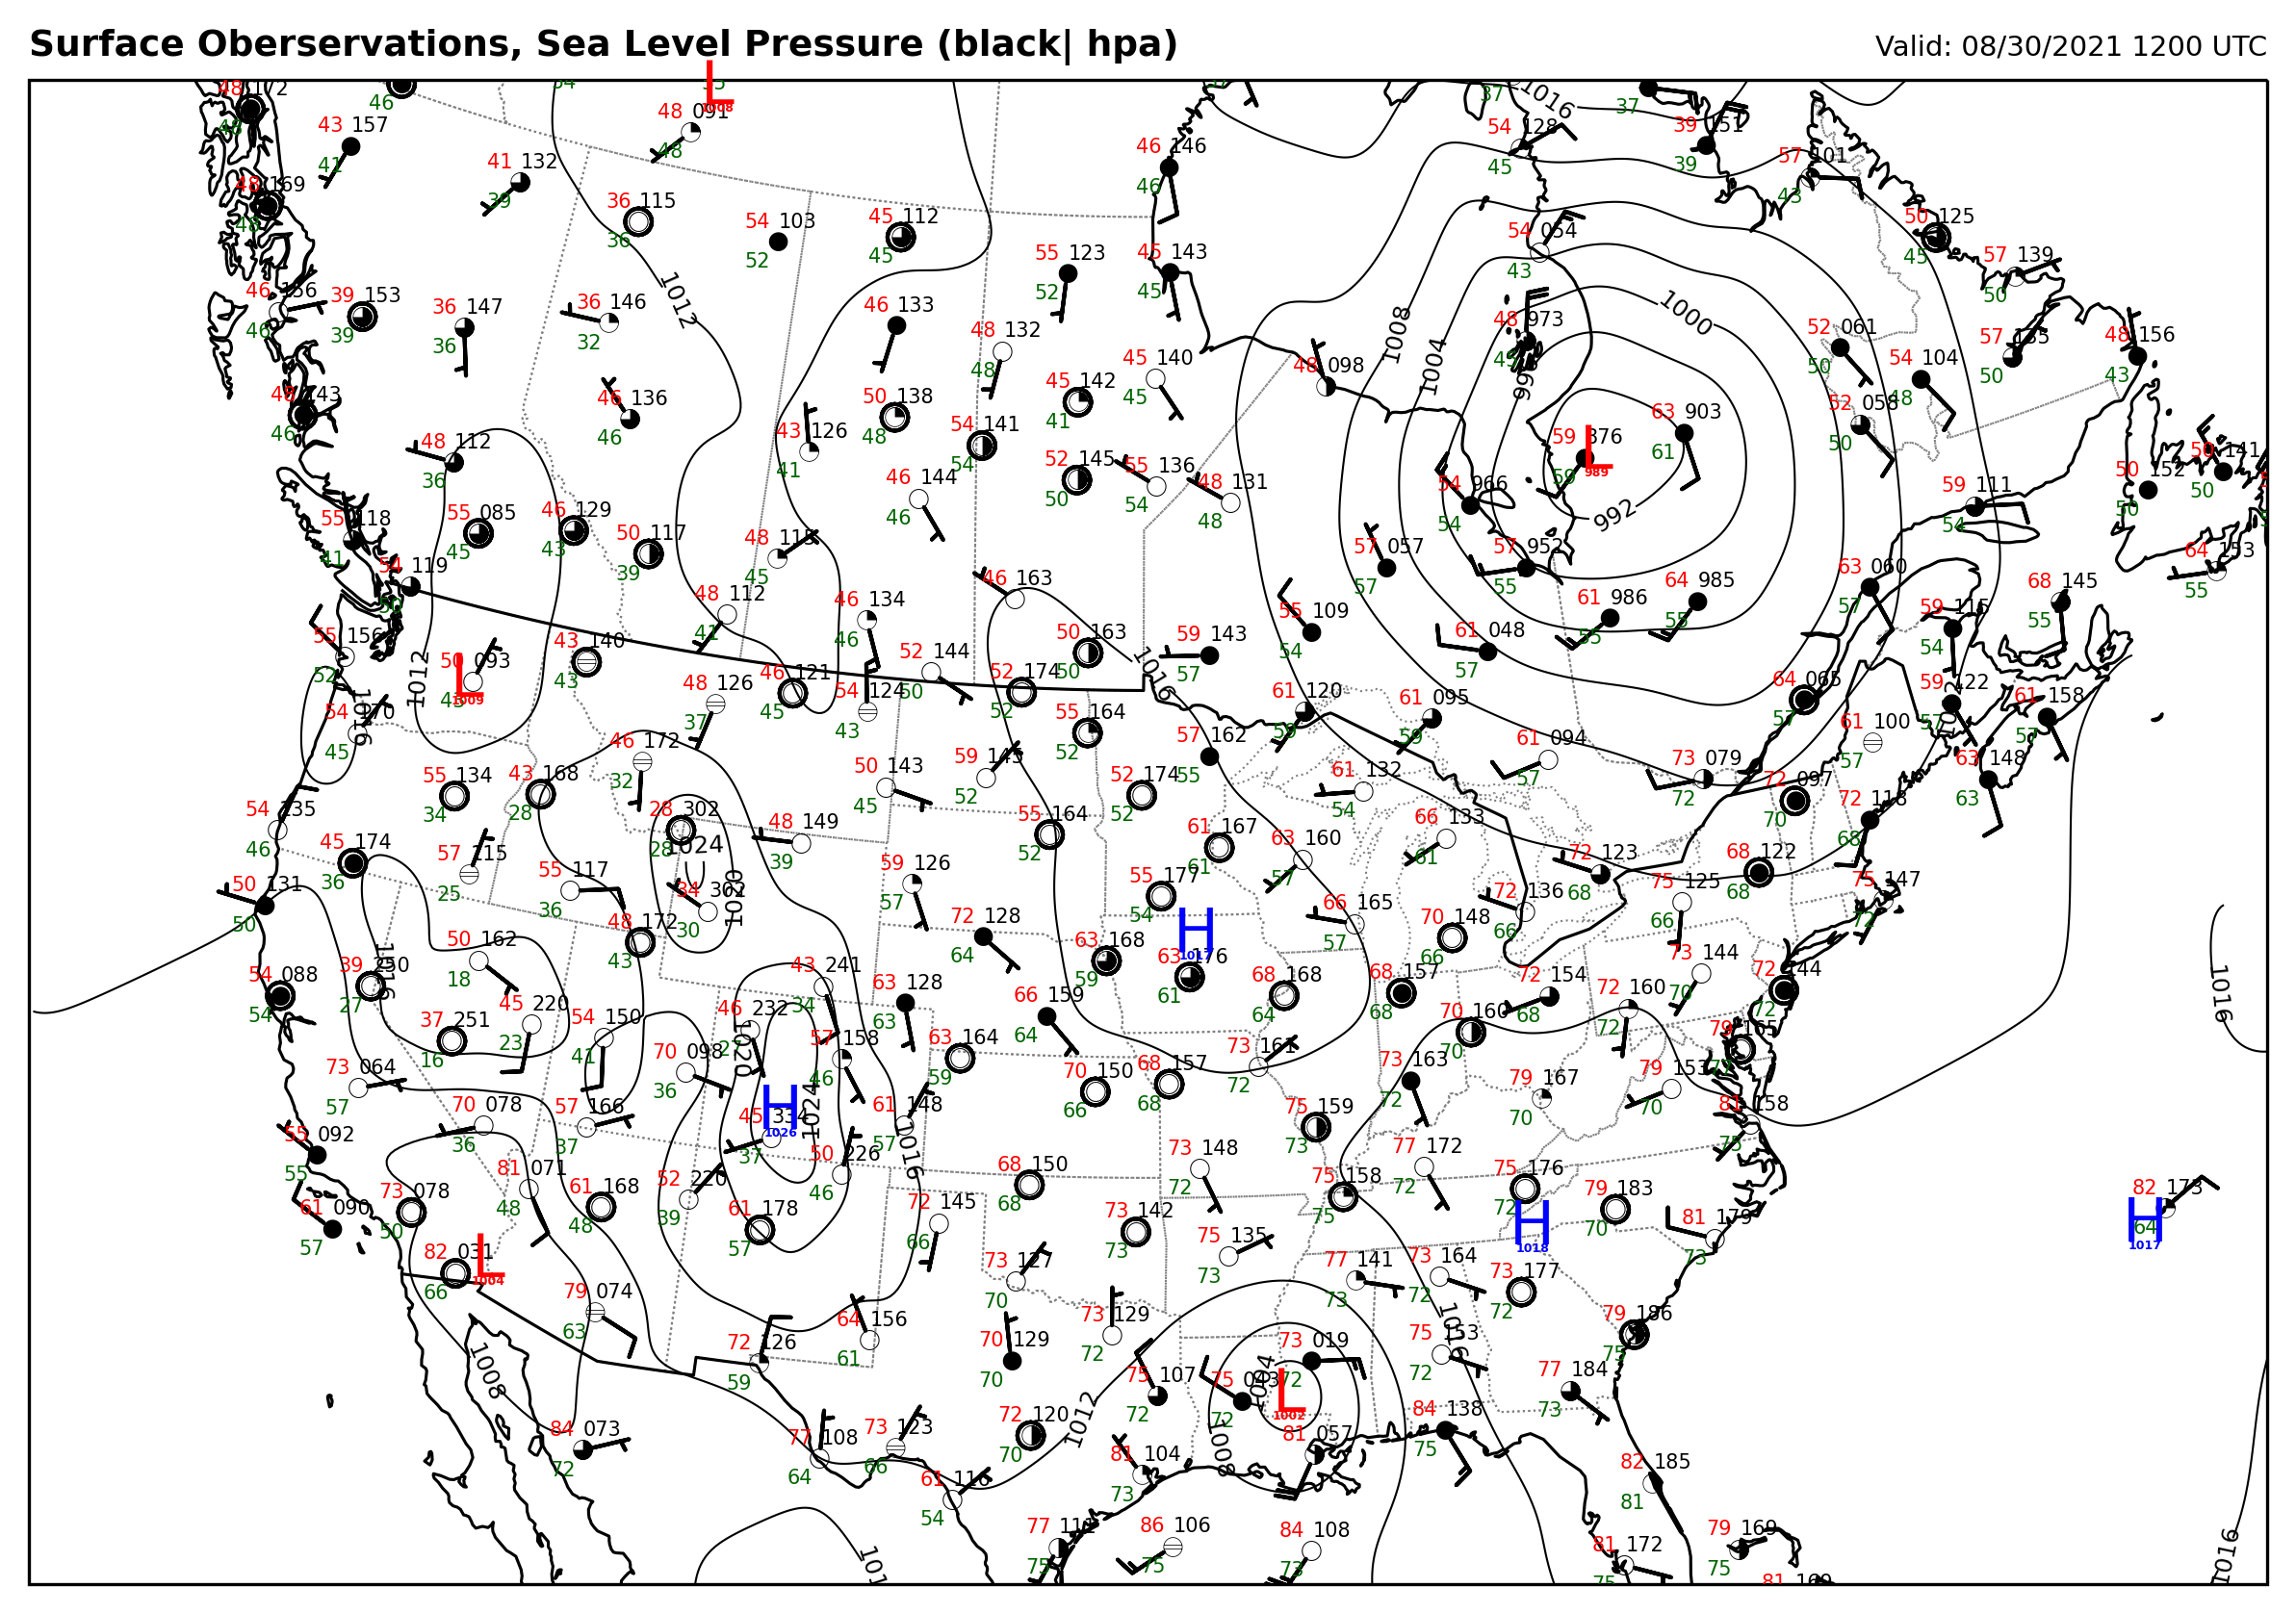

In [6]:
plot_surface( metar_data, file_time, new_pressure, new_lat, new_lon, proj)

<br /><br />
7.  Reuse the functions you have created to create another plot for July 28th, 2022 at 1200 UTC. Don't forget to first create a new datetime object for this time!

Downloading: 2022-07-28 00:00:00


/opt/tljh/user/lib/python3.7/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/opt/tljh/user/lib/python3.7/site-packages/cartopy/crs.py:877: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/opt/tljh/user/lib/python3.7/site-packages/cartopy/crs.py:944: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


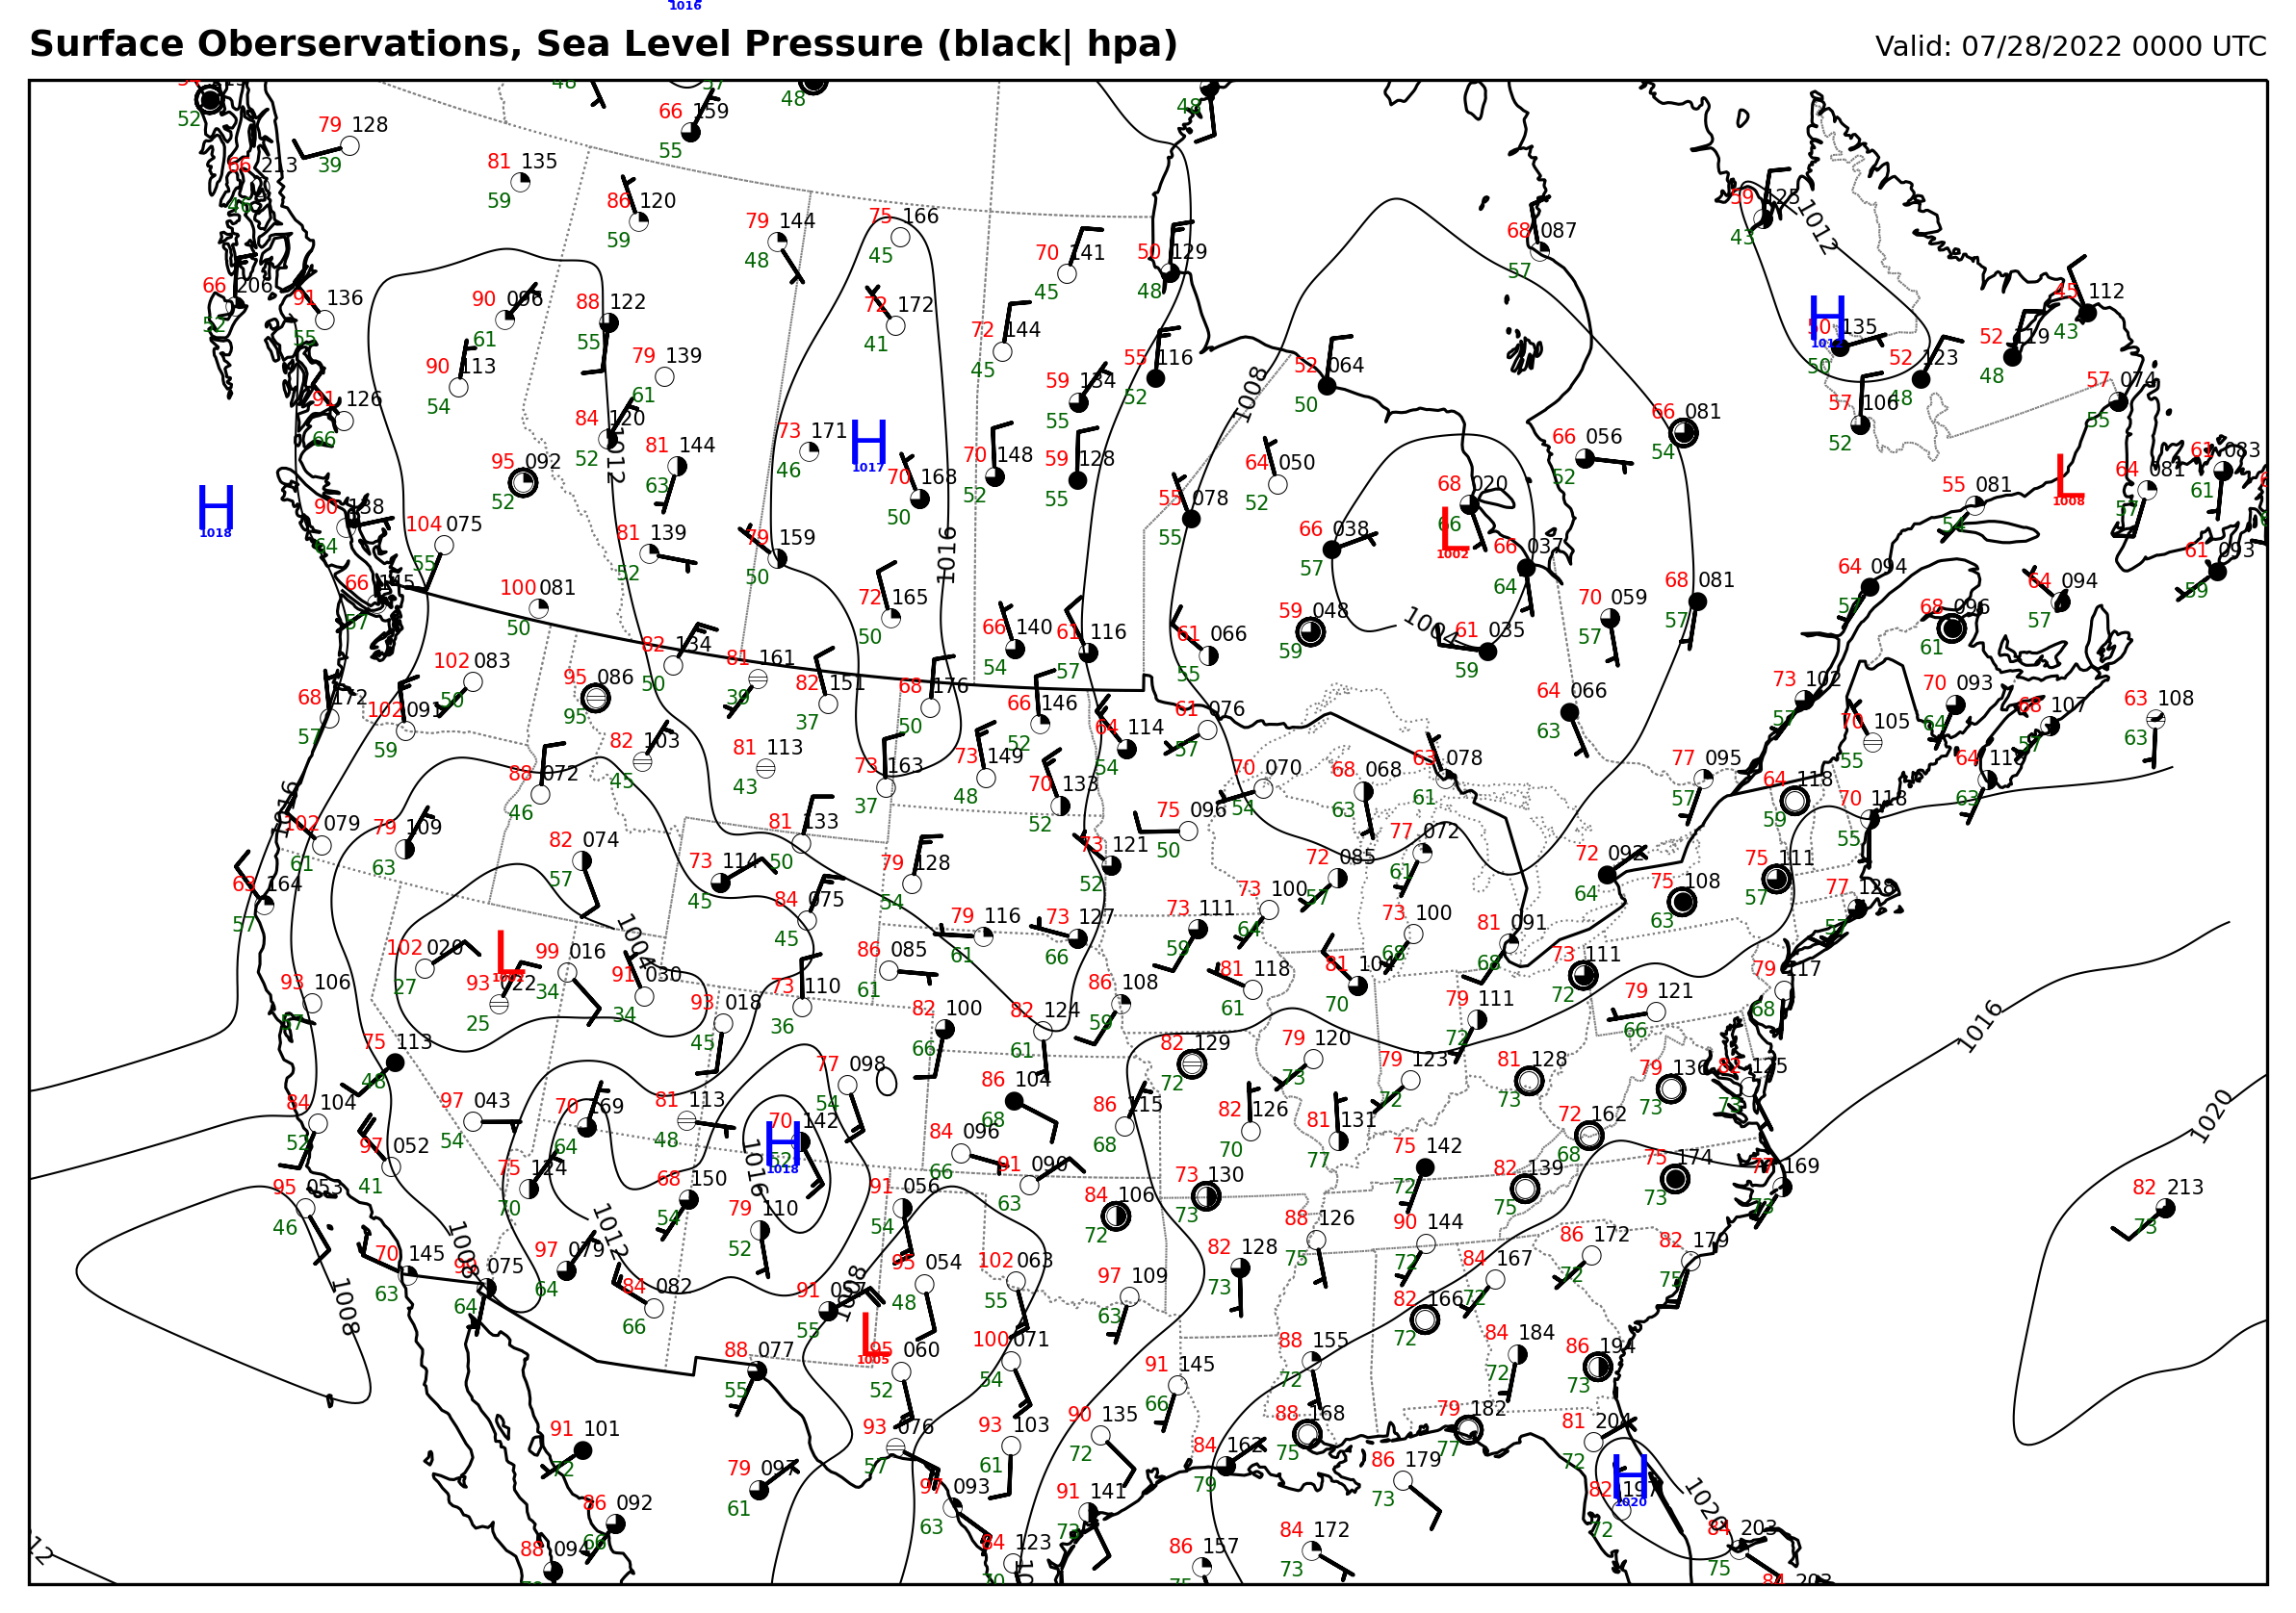

In [7]:
file_time=datetime(2022,7,28,0)
#using 0z here for consistency because 12z does not work for part 2 of lab but 0z does

metar_data, new_pressure, new_lat, new_lon, proj=process_surface_data(file_time)
plot_surface( metar_data, file_time, new_pressure, new_lat, new_lon, proj)


### You have now completed Part I of the Python portion of the lab.  Be sure to submit the fully rendered Jupyter Notebook on GitHub when you are finished.